# RNN zur Vorhersage der Position von Verkehrsteilnehmern

## Verwendete Packages

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow import keras
import requests
import random
from random import randint
import tensorflow as tf
import pandas as pd
import numpy as np
import zipfile
import urllib
import glob
import math

## Einstellungen
So, wie in der Übung habe ich ganz am Ende des Implementierens für numpy, random und tensorflow einen Seed<br>
festgelegt, damit für den Projektbericht reproduzierbare Ergebnisse vorliegen ([Quelle](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)).

In [ ]:
def random_seed(seed=2021):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
random_seed()

In [ ]:
plt.rcParams["figure.figsize"] = (14,8)

## Laden der .txt-Dateien

Zunächst sollen alle .txt-Dateien zusammengetragen werden.

In [11]:
url = 'https://homepages.ur.de/~hen58277/09_data.zip'
extract_dir = "Data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

In [12]:
# Dateinamen der .txt-Dateien ermitteln, die sich im Ordner Data/ befinden.
files = glob.glob("Data/09_data/*.txt")

# Die Daten zu den Fußgängern sollen in einem Dataframe gesammelt werden.
df = None

# Die Textdateien sollen alphabetisch sortiert werden, damit wir reproduzierbare
# Ergebnisse erhalten bei verschiedenen Laufzeiten. Die Textdateien werden von unterschiedlichen
# Laufzeitumgebungen in unterschiedlicher Reihenfolge eingelesen.
files.sort()

for f in files:
    txt = pd.read_csv(f,delimiter=" ",header=None)
    if df is None:
        df = txt
    else:
        df = df.append(txt)

# Spalten umbenennen, der Übersichtlichkeit halber.
df = df.set_axis(['timestamp', 'pedestrian_id', 'x', 'y'], axis=1, inplace=False)

# Durch das Zusammentragen der Dataframes der jeweiligen .txt-Datei 
# ist der Index nicht mehr individuell für jede Zeile des Dataframes.
# Daher wird hier das Zurücksetzen des Index ausgeführt.
df = df.reset_index(drop=True) 

# Geben wir nun das Ergebnis aus. 
df

,timestamp,pedestrian_id,x,y
0,0,100,1.728,14.378
1,12,100,2.035,14.378
2,24,100,2.342,14.378
3,36,100,2.630,14.378
4,48,100,2.937,14.416
...,...,...,...,...
108115,11424,273,-27.961,18.169
108116,11436,273,-28.388,17.967
108117,11448,273,-28.747,17.787
108118,11460,273,-29.107,17.608


# 1. Datenvorverarbeitung

## 1.0 Betrachtung der einzelnen Beispiele

In [ ]:
# Die Anzahl an Datenpunkten möchten wir zunächst in n_examples speichern.
example_range = 20
n_examples = int(df.shape[0] / example_range)
print("Anzahl an Beispiele: ", n_examples)

Anzahl an Beispiele:  5406


In [ ]:
# Diese Funktion gibt die Koordinaten eines Datenpunkts zurück (Rückgabe -> shape = (20, 2)).
def get_pedestrian_coordinates(pedestrian_df):
    
    # Nun sollen die x / y Werte in gewöhnlichen Listen gespeichert werden.
    x, y = pedestrian_df['x'].tolist() , pedestrian_df['y'].tolist()
    
    # Die 20 Koordinaten sollen in dem Array pedestrian_array gespeichert werden.
    pedestrian_array = np.array([])
    
    # Die Koordinaten speichern wir nun als Paare (inklusive Reshaping).
    for i in range(len(x)):
        pedestrian_array = np.append(pedestrian_array,[x[i],y[i]])
    pedestrian_array = pedestrian_array.reshape(example_range,2)
    return pedestrian_array

In [ ]:
X_raw = np.array([])

for example in range(n_examples):
    # Den Dataframe eines einzelnen Beispiels speichern wir zunächst pedestrian_df. 
    pedestrian_df = df[example*example_range:example*example_range+example_range]
    pedestrian_coordinates = get_pedestrian_coordinates(pedestrian_df)

    X_raw = np.append(X_raw,pedestrian_coordinates)
    
X_raw = X_raw.reshape(n_examples,40)

# Die Datenpunkte werden nun noch gemischt, damit möglichst aus jeder .txt-Datei Beispiele in einem
# zukünftigen Train/Test Datensatz sind. Dies wird bereits jetzt gemacht, da die übliche train_test_split-Funktion
# von sklearn zwar shuffle unterstützt, es hier aber meiner Erkenntnis nach unmöglich ist, bei den gemischten Datenpunkten im Delta-Format
# zurückzuverfolgen, zu welchen tatsächlichen Beispielen bzw. x/y Wertepaaren diese gehören. Allein aus Delta-Werten kann man ohne z.B. die Startposition
# zu kennen schließlich nicht schließen, wie die dazugehörige Trajektorie lautet. 
np.random.shuffle(X_raw)
    
# Damit jeder Index von X_raw einem Datenpunkt entspricht, wird nun noch ein Reshaping vorgenommen. 
X_raw = X_raw.reshape(n_examples,example_range,2)

# Geben wir nun mal das letzte Beispiel probeweise aus.
print("Beispiel Nr. ",n_examples,"\n \n",X_raw[n_examples-1])

Beispiel Nr.  5406 
 
 [[-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.315]
 [-24.293 -15.275]
 [-24.334 -15.275]
 [-24.334 -15.275]
 [-24.334 -15.275]]


## 1.1 Berechnung der relativen Änderung zwischen zwei Zeitpunkten (Delta)

In [ ]:
# Diese Funktion gibt für 20 Messungen von x oder y (einer Dimension) die daraus resultierenden 20 relative Änderung (Delta Wert)zurück. (Teilaufgabe 1.1)
def calculate_delta_for_array(raw_array):
    start_point = raw_array[0]
    delta_array = []
    for i in range(len(raw_array)):
        if i == 0:
            delta_array.append(0)
        else:
            delta_array.append(raw_array[i] - raw_array[i-1])
    return delta_array

# Beispiel aus der schriftlichen Ausarbeitung (Dafür Kommentar '#' entfernen)
# print("x-Werte absolut:\n\n",[10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29],"\n\nX-Werte relativ:\n\n",calculate_delta_for_array([10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]))

In [ ]:
# Wie in Teilaufgabe 1.1 beschrieben, möchten wir nur die relative Änderung betrachten. Diese berechnen wir nun.
X_raw_delta = X_raw.copy()
for i, x in enumerate(X_raw_delta):
    X_coordinates = calculate_delta_for_array(x[:,0])
    Y_coordinates = calculate_delta_for_array(x[:,1])
    for m in range(len(X_raw_delta[i])):
        X_raw_delta[i][m][0] = X_coordinates[m]
        X_raw_delta[i][m][1] = Y_coordinates[m]

# Nachdem wir nun die relativen Änderungen von jedem der 20 Messungen berechnet haben ergibt sich nun:
print("Originales Beispiel Nr. 1: \n\n",X_raw[0],"\n\n Nr. 1 nach Berechnung der relativen Änderung: \n\n",X_raw_delta[0])

Originales Beispiel Nr. 1: 

 [[ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]] 

 Nr. 1 nach Berechnung der relativen Änderung: 

 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


## 1.2 Weitere Vorverarbeitungsschritte
### 1.2.1 Erstellung der ersten acht und zukünftigen Messungenen (8 -> 12 Messungen)

In [ ]:
X = np.array([])
Y = np.array([])
for index in range(len(X_raw_delta)):
    # X speichert die ersten 8 Positionen eines Datenpunkts.
    X = np.append(X, X_raw_delta[index][:8])
    # Y speichert die letzten 12 Positionen eiens Datenpunkts.
    Y = np.append(Y, X_raw_delta[index][8:20])

X = X.reshape(n_examples,8,2)
Y = Y.reshape(n_examples,12,2)
# Um Transformation eines Beispiels auszugeben, bitte den das Kommentarzeichen '#' eine Zeile drunter entfernen.
# print("Beispiel Nr. 1: \n\n", "X: \n\n",X[0], "\n\n Y: \n\n",Y[0], "\n\n Vor Erstellung der beiden Blöcke: \n\n",X_raw_delta[0])

Wir haben nun also zum Trainieren Messungen für 8 Zeitpunkte(X) und wollen die darauffolgenden 12 (Y) vorhersagen. 

### 1.2.2 Erstellung von Trainings- und Testdatensatz

Wir teilen den Datensatz nun in Trainingsdaten(80%) und Testdaten(20%). Wir mischen die Daten nicht (shuffle=False), da dies nicht nochmal erforderlich ist.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
print("Anzahl an Trainingsdaten: ",len(X_train))
print("Anzahl an Testdaten: ", len(X_test))
train_size = len(X_train)
test_size = len(X_test)

Anzahl an Trainingsdaten:  4324
Anzahl an Testdaten:  1082


### 1.2.3 Anpassung der Form der Daten

Dann wird noch ein Reshaping auf die Trainingsdaten angewendet.

In [ ]:
# Anzahl an Zahlen, die wir vorhersagen möchten (12 timestamps * 2 values (x,y)).
n_predict = 24
Y_train = Y_train.reshape(len(Y_train),n_predict)
Y_test = Y_test.reshape(len(Y_test),n_predict)

### 1.2.4 Traineren eines Scalers anhand der Trainingsdaten

In [ ]:
# Skalieren wir nun noch die Daten.
scaler = StandardScaler()

# Passen wir nun den Scaler auf unsere Daten an. Hierfür verwenden wir X_train und Y_train.
# Der Scaler wird sowohl für die x-Koordinaten als auch für die y-Koordinaten gefittet. Daher ist der shape von data_scaled (n,2).
data_scaled =  np.append(X_train.reshape(-1,1), Y_train.reshape(-1,1)).reshape(int((len(X_train.reshape(-1,1)) + len(Y_train.reshape(-1,1)) ) / 2),2)
scaler.fit(data_scaled)

X_train = scaler.transform(X_train.reshape(-1,2)).reshape(X_train.shape)
Y_train = scaler.transform(Y_train.reshape(-1,2)).reshape(Y_train.shape)

# 2. Training des neuronalen Netzes

## 2.1 Erstellung der Architektur

In [ ]:
epochs = 20
time_steps = 8

def build_model():
    model = Sequential()
    model.add(LSTM(units=8, input_shape=(time_steps, 2)))
    model.add(Dense(n_predict, activation='linear'))
    model.compile(loss='mse', optimizer="adam", metrics=['mae'])
    return model

## 2.2 Training

In [ ]:
model = build_model()
model.summary()
# Um auch die Performance auf ungesehenen Daten in einer Graphik dazustelllen bzw. um Hyperparamter zu optimieren, spezifizieren wir, dass 20% zur Validation genommen werden sollen.
# Wir möchten uns außerdem den Verlauf des Trainings darstellen lassen. Daher speichern wir diesen in der Variable history.
history = model.fit(X_train, Y_train, epochs=epochs, verbose=1, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 352       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                216       
Total params: 568
Trainable params: 568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
109/109 [==============================] - 3s 9ms/step - loss: 0.8937 - mae: 0.5582 - val_loss: 0.6796 - val_mae: 0.5167
Epoch 2/20
109/109 [==============================] - 1s 5ms/step - loss: 0.7213 - mae: 0.4836 - val_loss: 0.5353 - val_mae: 0.4449
Epoch 3/20
109/109 [==============================] - 1s 5ms/step - loss: 0.5953 - mae: 0.4133 - val_loss: 0.4412 - val_mae: 0.3853
Epoch 4/20
109/109 [==============================] - 1s 5ms/step - loss: 0.5176 - mae: 0.3639 - val_loss: 0.3919 - val_ma

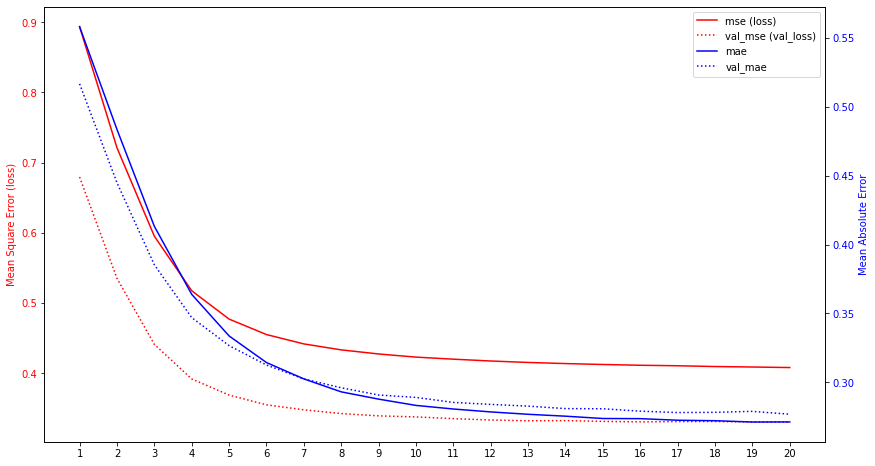

In [ ]:
# Da wir 20% der Trainingsdaten als Validationsdaten verwendet haben, können wir beide Kurven der Loss-Funktionen betrachten.
# Diese Methode wurde fast identisch in der 5. Studienleistung verwendet.
def plot_history(history):
    fig, ax1 = plt.subplots()
    plot_lines = []
    plot_lines+=ax1.plot(range(1,len(history.history['loss'])+1), history.history['loss'], label="mse (loss)", color="red")
    plot_lines+=ax1.plot(range(1,len(history.history['loss'])+1), history.history['val_loss'], label="val_mse (val_loss)", color="red", linestyle=":")
    ax1.set_xticks(range(1,len(history.history['loss'])+1))
    ax1.set_ylabel("Mean Square Error (loss)", color="red")
    ax1.tick_params(axis='y', labelcolor="red")
    ax2 = ax1.twinx()
    plot_lines+=ax2.plot(range(1,len(history.history['loss'])+1), history.history['mae'], label="mae", color="blue")
    plot_lines+=ax2.plot(range(1,len(history.history['loss'])+1), history.history['val_mae'], label="val_mae", color="blue", linestyle=":")
    ax2.set_ylabel("Mean Absolute Error", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")
    all_labels = [i.get_label() for i in plot_lines]
    ax1.legend(plot_lines, all_labels, loc=1)
    
plot_history(history)

In [ ]:
# Nun möchten wir aber alle Trainingsdaten verwenden, um unser Model zu trainieren.
# Daher bauen/trainieren wir das Model erneut, diesmal aber ohne 20% zum Validieren zu verwenden.
model = build_model()
model.fit(X_train, Y_train, epochs=epochs, verbose=0)

# 3. Bewertung der Ergebnisse

## 3.0 Vorhersagen betrachten 
Betrachten wir zunächst die Vorhersagen für die Trainingsdaten

In [ ]:
delta_predictions_train = scaler.inverse_transform(model.predict(X_train).reshape(-1,2)).reshape(Y_train.shape)
delta_predictions_train = delta_predictions_train.reshape(train_size,12,2)

# Betrachten wir probeweise mal das erste Beispiel und vergleichen es mit den tatsächlichen Werten (Y_train).
print("Prediction: \n\n",delta_predictions_train[0])
print("\nLabel: \n\n",Y_train[0].reshape(12,2))

Prediction: 

 [[-0.00211751  0.0052857 ]
 [-0.00206071  0.00295275]
 [ 0.00139194  0.0029946 ]
 [-0.00566402 -0.0111026 ]
 [-0.00178263  0.00024723]
 [-0.00245442 -0.0059504 ]
 [-0.00444067  0.00381452]
 [-0.00497377 -0.00387807]
 [-0.00532602 -0.00506807]
 [-0.00519252 -0.00048904]
 [-0.0089922  -0.00357349]
 [-0.00521715 -0.00545649]]

Label: 

 [[0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]
 [0.01541555 0.0815599 ]]


Betrachten wir nun noch die Vorhersagen für Testdaten.

In [ ]:
delta_predictions_test = scaler.inverse_transform(model.predict(scaler.transform(X_test.reshape(-1,2)).reshape(X_test.shape)).reshape(-1,2)).reshape(Y_test.shape)
delta_predictions_test = delta_predictions_test.reshape(test_size,12,2)

# Betrachten wir probeweise mal das erste Beispiel und vergleichen es mit den tatsächlichen Werten (Y_test).
print("Prediction: \n\n",delta_predictions_test[0])
print("\nLabel: \n\n",Y_test[0].reshape(12,2))

Prediction: 

 [[-0.00331605  0.02209085]
 [ 0.0001858   0.01729932]
 [ 0.00066437  0.02012998]
 [-0.00524929  0.00408645]
 [-0.00074841  0.01510501]
 [-0.00281477  0.01144601]
 [-0.00632687  0.01917159]
 [-0.00514385  0.01189606]
 [-0.00479305  0.01071608]
 [-0.00664219  0.01336936]
 [-0.01032893  0.00950966]
 [-0.00552701  0.00756387]]

Label: 

 [[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.038 0.   ]
 [0.    0.   ]
 [0.    0.038]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]


Nun wollen wir die skalierten X_train und Y_train aber wieder in Delta-Werte umformatieren für den danach folgenden Code.

In [ ]:
X_train = scaler.inverse_transform(X_train.reshape(-1,2)).reshape(X_train.shape)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,2)).reshape(Y_train.shape)

## 3.1 Berechnung der zukünftigen Position in Meter

In [ ]:
# Zunächst brauchen wir eine Funktion, die Delta-Werte wieder in absolute x/y Werte in Meter umwandelt.
# dataset (Array) := Der Datensatz (entweder trainig oder test), 
# isTestData (boolean) := Die Funktion muss wissen, ob es ich um Testdaten handelt
# isPredictedSequence (boolean):= Die Funktion muss wissen, ob es sich um Trajektorien handelt, die zum Vorhesagen dienen oder um Trajektorien, die vorhergesagt werden sollen.
def transform_to_absolute_points(dataset, isTestData, isPredictedSequence):
    startIndex = 0
    if isTestData:
        startIndex = train_size
    for i in range(len(dataset)):
        for k in range(len(dataset[i])):
            if k == 0:
                if isPredictedSequence:
                    dataset[i][k][0] , dataset[i][k][1] = X_raw[i+startIndex][k+7][0] + dataset[i][k][0] , X_raw[i+startIndex][k+7][1] + dataset[i][k][1]
                else:
                    dataset[i][k][0] , dataset[i][k][1] = X_raw[i+startIndex][k][0] , X_raw[i+startIndex][k][1]
            else:
                    dataset[i][k][0] , dataset[i][k][1] = dataset[i][k-1][0] + dataset[i][k][0] , dataset[i][k-1][1] + dataset[i][k][1]
    return dataset

In [ ]:
# Dass diese Funktion funktioniert, kann man einfach mal testen, indem man die Trainingsdaten im Delta-Format
# übergibt und dann schaut, ob diese nach Transformation übereinstimmen mit den Tatsächlichen.
print("Transformation: \n\n", transform_to_absolute_points(X_train[:1].copy(), False, False))
print("\nOriginal: \n\n",X_raw.copy()[0][:8],"\n")

# Das funktioniert natürlich auch mit den Trajektorien, die vorhergesagt werden sollen.
# Dafür einfach die '#' in den nächsten beiden Zeilen entfernen.
# print("Transformation; \n", transform_to_absolute_points(Y_train[:1].reshape(1,12,2).copy(), False, True))
# print("\nOriginal: \n",X_raw[0][8:20])

Transformation: 

 [[[ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]
  [ 16.208 -10.644]]]

Original: 

 [[ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]
 [ 16.208 -10.644]] 



## 3.2 Prädizierte Trajektorie

Berechnen wir nun aber endlich anhand der Funktion die Trajektorien, die das RNN vorhersagt.

In [ ]:
predicted_trajectories_train = transform_to_absolute_points(delta_predictions_train.copy(),False,True)
predicted_trajectories_test = transform_to_absolute_points(delta_predictions_test.copy(),True,True)

Sehen wir uns nun mal probeweise die Vorhersage des 1. Beispiels unserer Testdaten an.

In [ ]:
print("Prediction: \n\n",predicted_trajectories_test[0],"\n\nLabel: \n\n",X_raw[train_size+0][8:20])

Prediction: 

 [[15.298684 -9.52391 ]
 [15.29887  -9.50661 ]
 [15.299535 -9.48648 ]
 [15.294286 -9.482393]
 [15.293537 -9.467288]
 [15.290722 -9.455842]
 [15.284395 -9.43667 ]
 [15.279251 -9.424774]
 [15.274458 -9.414058]
 [15.267816 -9.400688]
 [15.257486 -9.391178]
 [15.25196  -9.383615]] 

Label: 

 [[15.302 -9.546]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.34  -9.546]
 [15.34  -9.546]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]]


Nun können wir noch vier zufällige Beispiele anzeigen lassen. <br> <b>Hinweis: </b>Die folgende Zelle kann beliebig häufig aufgerufen werden, um andere zufällige Beispiele zu betrachten.<br>Möchte man ganz bestimmte Testbeispiele eingeben, müssen einfach vier Indexe der Variable random_predictions zugeordnet werden. Also beispielsweise:<br>```random_predictions = [0,1,2,3]```, um die ersten vier auszugeben.

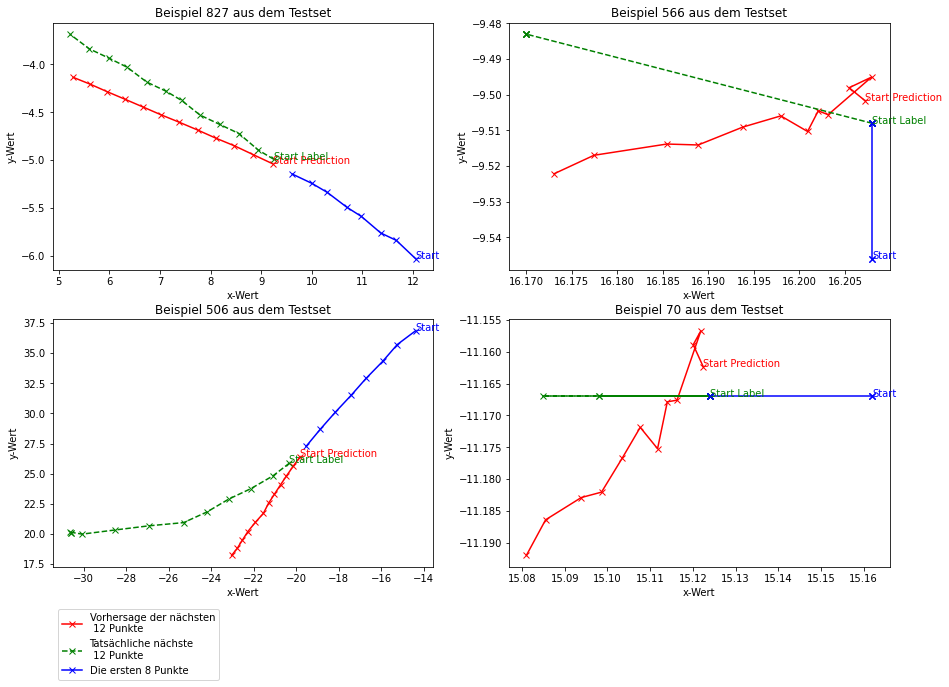

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.setp(ax.flat, xlabel='x-Wert', ylabel='y-Wert')
index = 0

random_predictions = [randint(0,test_size) for p in range(0,4)]

for row in ax:
    for col in row:
        col.plot(predicted_trajectories_test[random_predictions[index]][:,0], predicted_trajectories_test[random_predictions[index]][:,1], 'rx-', label="Vorhersage der nächsten\n 12 Punkte")
        col.plot(X_raw[train_size+random_predictions[index]][:,0][8:], X_raw[train_size+random_predictions[index]][:,1][8:], 'gx--',label="Tatsächliche nächste\n 12 Punkte")
        col.plot(X_raw[train_size+random_predictions[index]][:,0][:8], X_raw[train_size+random_predictions[index]][:,1][:8], 'bx-', label="Die ersten 8 Punkte")
        col.title.set_text('Beispiel '+str(random_predictions[index])+' aus dem Testset')
        col.text(X_raw[train_size+random_predictions[index]][:,0][:8][0],X_raw[train_size+random_predictions[index]][:,1][:8][0],"Start",color="b")
        col.text(predicted_trajectories_test[random_predictions[index]][:,0][0],predicted_trajectories_test[random_predictions[index]][:,1][0],"Start Prediction",color="r")
        col.text(X_raw[train_size+random_predictions[index]][:,0][8:][0],X_raw[train_size+random_predictions[index]][:,1][8:][0],"Start Label",color="g")
        if index == 2:
            col.legend(loc="upper left",bbox_to_anchor=(0, -0.15))

        index += 1

plt.show()

In [ ]:
# Alternativ können wir auch die Trajektorie eines bestimmten Beispiels unserer Testmenge ausgeben lassen als Arrays. 
# Exemplarisch für das 1. Beispiel:
index_of_test_data = 0
print("Tatsächliche Trajektorie: \n\n",X_raw[train_size+index_of_test_data])
print("\n\nVorhergesagte Trajektorie der letzten 12 Punkte: \n\n",predicted_trajectories_test[index_of_test_data])

Tatsächliche Trajektorie: 

 [[15.264 -9.572]
 [15.264 -9.572]
 [15.264 -9.572]
 [15.264 -9.572]
 [15.302 -9.572]
 [15.302 -9.572]
 [15.302 -9.572]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.302 -9.546]
 [15.34  -9.546]
 [15.34  -9.546]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]
 [15.34  -9.508]]


Vorhergesagte Trajektorie der letzten 12 Punkte: 

 [[15.298684 -9.52391 ]
 [15.29887  -9.50661 ]
 [15.299535 -9.48648 ]
 [15.294286 -9.482393]
 [15.293537 -9.467288]
 [15.290722 -9.455842]
 [15.284395 -9.43667 ]
 [15.279251 -9.424774]
 [15.274458 -9.414058]
 [15.267816 -9.400688]
 [15.257486 -9.391178]
 [15.25196  -9.383615]]


## 3.3 Evaluation anhand Mean Squared Error / Mean Absolute Error

In [ ]:
testScore = mean_absolute_error(transform_to_absolute_points(Y_test.copy().reshape(test_size,12,2), True, True).reshape(test_size,n_predict), predicted_trajectories_test.copy().reshape(test_size,n_predict))
print("Mean Absolute Error Score (Test):  ",testScore)
trainScore = mean_absolute_error(transform_to_absolute_points(Y_train.copy().reshape(train_size,12,2), False, True).reshape(train_size,n_predict), predicted_trajectories_train.copy().reshape(train_size,n_predict))
print("Mean Absolute Error Score (Train)",trainScore)
testScore = mean_squared_error(transform_to_absolute_points(Y_test.copy().reshape(test_size,12,2), True, True).reshape(test_size,n_predict), predicted_trajectories_test.copy().reshape(test_size,n_predict))
print("Mean Squared Error Score (Test):  ",testScore)
trainScore = mean_squared_error(transform_to_absolute_points(Y_train.copy().reshape(train_size,12,2), False, True).reshape(train_size,n_predict), predicted_trajectories_train.copy().reshape(train_size,n_predict))
print("Mean Squared Error Score (Train)",trainScore)

Mean Absolute Error Score (Test):   0.4323312445027794
Mean Absolute Error Score (Train) 0.42460563018565683
Mean Squared Error Score (Test):   0.8724779445229297
Mean Squared Error Score (Train) 0.9211925032112113


Wir können für zwei zufällige Datenpunkte des Testdatensatzes die Abweichung der Vorhersage |Y<sub>Label</sub> - Ŷ<sub>Prediction</sub>| der einzelnen Koordinaten-Werte (24 Stück) berechnen.

In [ ]:
labels_train_absolute = transform_to_absolute_points(Y_train.copy().reshape(train_size,12,2), False, True).reshape(train_size,n_predict).reshape(-1,1)
predicted_train_absolute = predicted_trajectories_train.copy().reshape(train_size,n_predict).reshape(-1,1)

labels_test_absolute = transform_to_absolute_points(Y_test.copy().reshape(test_size,12,2), True, True).reshape(test_size,n_predict).reshape(-1,1)
predicted_test_absolute = predicted_trajectories_test.copy().reshape(test_size,n_predict).reshape(-1,1)



for i in [randint(0,test_size) for p in range(0,2)]:
    print("\nAbweichungen der Werte bei Beispiel "+str(i)+": \n")
    pred = predicted_test_absolute[24*(i-1):24*i]
    label = labels_test_absolute[24*(i-1):24*i]
    for k in range(len(label)):
        print(i, k, abs(label[k] - pred[k]))


Abweichungen der Werte bei Beispiel 908: 

908 0 [0.01649171]
908 1 [0.00097971]
908 2 [0.02511483]
908 3 [0.00328226]
908 4 [0.07623937]
908 5 [0.00977392]
908 6 [0.09454706]
908 7 [0.0022561]
908 8 [0.10831335]
908 9 [0.00205355]
908 10 [0.16576647]
908 11 [0.0077365]
908 12 [0.18678593]
908 13 [0.00536757]
908 14 [0.20210527]
908 15 [0.01235037]
908 16 [0.21429752]
908 17 [0.01336317]
908 18 [0.23862051]
908 19 [0.01675444]
908 20 [0.25858282]
908 21 [0.01728278]
908 22 [0.31177159]
908 23 [0.01855879]

Abweichungen der Werte bei Beispiel 970: 

970 0 [0.01236621]
970 1 [0.00333408]
970 2 [0.03756662]
970 3 [0.00575069]
970 4 [0.01689426]
970 5 [0.00174138]
970 6 [0.0081414]
970 7 [0.01697156]
970 8 [0.04901227]
970 9 [0.23398874]
970 10 [0.13951347]
970 11 [1.16369698]
970 12 [0.24487959]
970 13 [2.03708264]
970 14 [0.30877335]
970 15 [2.96894182]
970 16 [0.3786979]
970 17 [2.96018137]
970 18 [0.40328749]
970 19 [2.76873973]
970 20 [0.49351434]
970 21 [2.58429752]
970 22 [0.548538

## 3.4 Perzentile
### Perzentile aller Daten

Wir können auch alle Prognosefehlerwerte der Testdaten betrachten und z.B. Perzentile berechnen. 

10% Perzentil: 0.0065239013671867276
20% Perzentil: 0.01688534851074266
30% Perzentil: 0.036124394226074406
40% Perzentil: 0.06956552734374953
50% Perzentil: 0.12628157043456945
60% Perzentil: 0.21609199600219747
70% Perzentil: 0.36928187437057486
80% Perzentil: 0.6331109851837159
90% Perzentil: 1.174260047912598


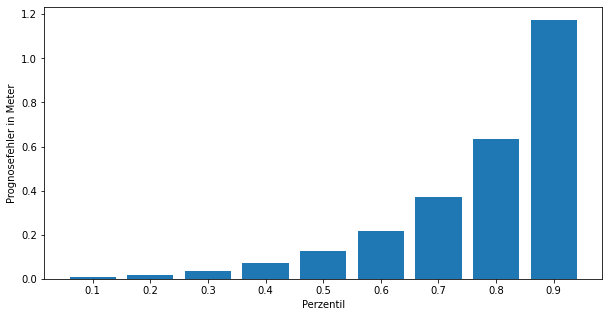

Median:  0.12628157043456945


In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

prognose_fehler_testdaten = np.array([])

for i in range(len(predicted_test_absolute)):
    prognose_fehler_testdaten = np.append(prognose_fehler_testdaten,abs(labels_test_absolute[i]-predicted_test_absolute[i]))

idx = 10
for p in np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]):
    print(str(idx)+"% Perzentil:", p)
    idx += 10

plt.bar(["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"],np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]))
plt.ylabel('Prognosefehler in Meter')
plt.xlabel('Perzentil')
plt.show()
print("Median: ",np.median(np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90])))

### Perzentile für die erste Position

10% Perzentil: 0.0021177139282224644
20% Perzentil: 0.005283487701413847
30% Perzentil: 0.006757387161255489
40% Perzentil: 0.01515867156982438
50% Perzentil: 0.026386398315429105
60% Perzentil: 0.040472005462647134
70% Perzentil: 0.06029169616699121
80% Perzentil: 0.09005695037841921
90% Perzentil: 0.1514321529388431


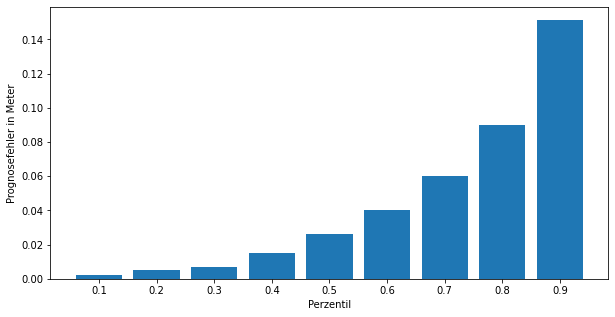

Median:  0.026386398315429105


In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

prognose_fehler_testdaten = np.array([])

k = 0
for i in range(len(predicted_test_absolute)):
    if k == 0 or k == 1:
        prognose_fehler_testdaten = np.append(prognose_fehler_testdaten,abs(labels_test_absolute[i]-predicted_test_absolute[i]))
    k += 1
    if k == 24:
        k = 0

idx = 10
for p in np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]):
    print(str(idx)+"% Perzentil:", p)
    idx += 10

plt.bar(["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"],np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]))
plt.ylabel('Prognosefehler in Meter')
plt.xlabel('Perzentil')
plt.show()
print("Median: ",np.median(np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90])))

### Perzentile für die letzte Position

10% Perzentil: 0.020223934555054245
20% Perzentil: 0.04682966327667226
30% Perzentil: 0.10116813755035378
40% Perzentil: 0.20266705627441375
50% Perzentil: 0.3661966381073003
60% Perzentil: 0.6032916908264163
70% Perzentil: 0.9306065757751474
80% Perzentil: 1.3555083171844489
90% Perzentil: 2.193187027359009


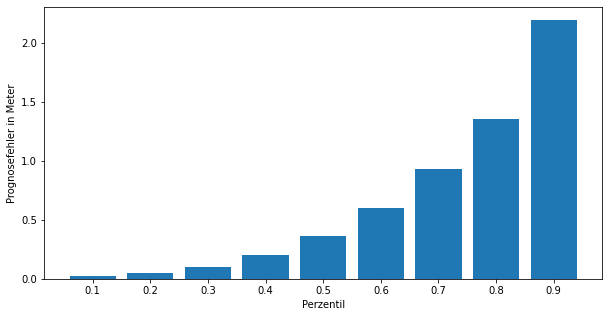

Median:  0.3661966381073003


In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

prognose_fehler_testdaten = np.array([])

k = 0
for i in range(len(predicted_test_absolute)):
    if k == 22 or k == 23:
        prognose_fehler_testdaten = np.append(prognose_fehler_testdaten,abs(labels_test_absolute[i]-predicted_test_absolute[i]))
    k += 1
    if k == 24:
        k = 0

idx = 10
for p in np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]):
    print(str(idx)+"% Perzentil:", p)
    idx += 10

plt.bar(["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"],np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90]))
plt.ylabel('Prognosefehler in Meter')
plt.xlabel('Perzentil')
plt.show()
print("Median: ",np.median(np.percentile(prognose_fehler_testdaten, [10,20,30,40,50,60,70,80,90])))

# 4. Zusätzlicher Code zur schriftlichen Ausarbeitung

In [ ]:
from sklearn.preprocessing import StandardScaler
data = [[0, 2], 
        [0, 1], 
        [1, 1], 
        [1, 2]]
scaler = StandardScaler()
scaler.fit(data)
print(scaler.mean_) 
print(scaler.transform(data)) # Daten nach Transformation

[0.5 1.5]
[[-1.  1.]
 [-1. -1.]
 [ 1. -1.]
 [ 1.  1.]]
